In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime, timedelta
import pandas as pd
import swifter
import numpy as np
import requests
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import keras
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import random
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
tqdm.pandas()

In [2]:
basedir = 'test/MouseDynamics'
training_path = os.path.join(basedir, 'training_files')
profiles = {}
for user in os.listdir(training_path):
    path_user = os.path.join(training_path, user)
    profiles[user] = {}
    for profile in os.listdir(path_user):
        path_profile = os.path.join(path_user, profile)
        profiles[user][profile] = pd.read_csv(path_profile)
        
test_path = os.path.join(basedir, 'test_files')
for user in os.listdir(test_path):
    path_user = os.path.join(test_path, user)
    profiles[f'{user}_test'] = {}
    for profile in os.listdir(path_user):
        path_profile = os.path.join(path_user, profile)
        profiles[f'{user}_test'][profile] = pd.read_csv(path_profile)
df_labels = pd.read_csv(os.path.join(basedir, 'public_labels.csv'))

In [3]:
profiles['user9']['session_0335985747']

,record timestamp,client timestamp,button,state,x,y
0,0.000,0.000,NoButton,Move,424,437
1,0.102,0.000,NoButton,Move,425,435
2,0.102,0.016,NoButton,Move,426,434
3,0.102,0.032,NoButton,Move,426,433
4,0.102,0.032,NoButton,Move,426,431
...,...,...,...,...,...,...
54413,2997.917,2997.497,NoButton,Move,245,317
54414,2997.917,2997.513,NoButton,Move,246,318
54415,2997.918,2997.513,NoButton,Move,247,318
54416,2997.918,2997.528,NoButton,Move,248,319


In [4]:
def parse_standard_resolution(x_max, y_max):
    """ Parses an appropriate screen resolution

        Parameters:
            x_max (int): maximum x coordinate
            y_max (int): maximum y coordinate

        Returns:
            x_std (int), y_std(int): standard screen resolution
    """
    x_standard = [320, 360, 480, 720, 768, 1024, 1280, 1360, 1366, 1440, 1600, 1680, 1920]
    y_standard = [480, 568, 640, 720, 768, 800, 900, 1024, 1050, 1080, 1200, 1280]

    # Parsing x coordinate
    x_pos = 0
    while x_standard[x_pos] < x_max and x_pos < len(x_standard) - 1:
        x_pos += 1

    # Parsing y coordinate
    y_pos = 0
    while y_standard[y_pos] < y_max and y_pos < len(y_standard) - 1:
        y_pos += 1

    if x_max > x_standard[x_pos]:
        x_standard[x_pos] = x_max

    if y_max > y_standard[y_pos]:
        y_standard[y_pos] = y_max

    return x_standard[x_pos], y_standard[y_pos]


In [5]:
def process_df(df):
    columns = ['x', 'y', 'client timestamp']
    columns_2 = ['veloc', 'theta', 'client timestamp']
    df_filtered = df[(df['client timestamp'].diff()>0) & (df['state']=='Move')]
    resolution_x, resolution_y = parse_standard_resolution(df.x.max(), df.y.max())
    df_filtered['x'] = df_filtered['x']/resolution_x
    df_filtered['y'] = df_filtered['y']/resolution_y
    diff = df_filtered[columns].diff()
    diff.rename(columns={'x': 'dx', 'y': 'dy', 'client timestamp': 'dt'}, inplace=True)
    diff['dx/dt'] = diff['dt'].where(diff['dt']==0, diff['dx']/diff['dt'])
    diff['dy/dt'] = diff['dt'].where(diff['dt']==0, diff['dy']/diff['dt'])
    diff['veloc'] = (diff['dx/dt'] * diff['dx/dt'] + diff['dy/dt'] * diff['dy/dt']) ** (1/2)
    diff['theta'] = np.where(np.isnan(diff['dx']), 0, np.arctan(diff['dy']/diff['dx']))
    tmp = pd.concat([df_filtered, diff], axis=1)
    diff_2 = tmp[columns_2].diff()
    diff_2.rename(columns={'veloc': 'dveloc', 'theta': 'dtheta','client timestamp': 'dt'}, inplace=True)
    diff_2['accel'] = diff_2['dt'].where(diff_2['dt']==0, diff_2['dveloc'].abs() / diff_2['dt'])
    diff_2['dtheta/dt'] = diff_2['dt'].where(diff_2['dt']==0, diff_2['dtheta'].abs() / diff_2['dt'])
    diff_2.drop('dt', axis=1, inplace=True)
    result = pd.concat([tmp, diff_2], axis=1).convert_dtypes(dtype_backend='pyarrow')
    result.dropna(inplace=True, ignore_index=True)
    return result


In [6]:
profiles_processed = {}
n_sessions = 0
with pd.option_context('mode.use_inf_as_na', True):
    for user in profiles:
        profiles_processed[user] = {}
        for profile in profiles[user]:
            profiles_processed[user][profile] = process_df(profiles[user][profile])
            n_sessions += 1

In [7]:
profiles_processed['user9']['session_0335985747']

,record timestamp,client timestamp,button,state,x,y,dx,dy,dt,dx/dt,dy/dt,veloc,theta,dveloc,dtheta,accel,dtheta/dt
0,0.102,0.047,NoButton,Move,0.006516,0.006531,0.000015,-0.000076,0.015,0.001017,-0.005086,0.005187,-1.373401,0.004233,0.197396,0.282225,13.159704
1,0.103,0.063,NoButton,Move,0.006516,0.006424,0.000000,-0.000107,0.016,0.000000,-0.006676,0.006676,-1.570796,0.001489,-0.197396,0.093047,12.337222
2,0.103,0.078,NoButton,Move,0.006500,0.006409,-0.000015,-0.000015,0.015,-0.001017,-0.001017,0.001439,0.785398,-0.005237,2.356194,0.349146,157.079634
3,0.103,0.094,NoButton,Move,0.006455,0.006378,-0.000046,-0.000031,0.016,-0.002861,-0.001907,0.003439,0.588003,0.002000,-0.197396,0.124996,12.337222
4,0.103,0.110,NoButton,Move,0.006363,0.006363,-0.000092,-0.000015,0.016,-0.005722,-0.000954,0.005801,0.165149,0.002362,-0.422854,0.147656,26.428371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27420,2997.917,2997.466,NoButton,Move,0.003601,0.004746,0.000092,0.000061,0.016,0.005722,0.003815,0.006877,0.588003,0.000363,-0.086738,0.022716,5.421146
27421,2997.917,2997.482,NoButton,Move,0.003677,0.004791,0.000076,0.000046,0.016,0.004768,0.002861,0.005561,0.540420,-0.001316,-0.047583,0.082265,2.973944
27422,2997.917,2997.497,NoButton,Move,0.003723,0.004822,0.000046,0.000031,0.015,0.003052,0.002035,0.003668,0.588003,-0.001893,0.047583,0.126207,3.172207
27423,2997.917,2997.513,NoButton,Move,0.003754,0.004852,0.000031,0.000031,0.016,0.001907,0.001907,0.002697,0.785398,-0.000970,0.197396,0.060648,12.337222


In [8]:
size = 300
sample_data_veloc = {}
# variables = ['veloc', 'accel', 'theta', 'dtheta/dt']
variables = ['dx', 'dy', 'dt']
# variables = ['x', 'y', 'dt']
# variables = ['veloc', 'dtheta/dt']
# variables = ['veloc', 'theta']
# predict_val = ['veloc', 'theta']
# predict_val = ['accel', ]
predict_val = ['dtheta/dt', ]
data = np.zeros((n_sessions, size, len(variables)))
output =  np.zeros((n_sessions, size, len(predict_val)))
count = 0
profiles_ids = []
for user in profiles_processed:
    for profile in profiles_processed[user]:
        aux = profiles_processed[user][profile][variables+predict_val][:size].to_numpy('float32')
        data[count] = np.pad(aux, ((0, size-len(aux)), (0, 0)), 'constant', constant_values=0)[:, 0:len(variables)]
        output[count] = np.pad(aux, ((0, size-len(aux)), (0, 0)), 'constant', constant_values=0)[:, len(variables):]
        profiles_ids.append(profile)
        count += 1

In [9]:
data.shape

(1676, 300, 3)

In [10]:
def build_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(size, len(variables))))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    # model.add(keras.layers.Conv1D(64, 3, activation='relu'))
    # model.add(keras.layers.AveragePooling1D(pool_size=2))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(32, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    # model.add(keras.layers.Conv1D(32, 3, activation='relu'))
    # model.add(keras.layers.AveragePooling1D(pool_size=2))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(16, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    # model.add(keras.layers.Conv1D(16, 3, activation='relu'))
    # model.add(keras.layers.AveragePooling1D(pool_size=2))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(8, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    # model.add(keras.layers.Conv1D(8, 3, activation='relu'))
    # model.add(keras.layers.AveragePooling1D(pool_size=2))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(4, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    # model.add(keras.layers.Conv1D(4, 3, activation='relu'))
    # model.add(keras.layers.AveragePooling1D(pool_size=2))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(2, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    # model.add(keras.layers.Conv1D(2, 3, activation='relu'))
    # model.add(keras.layers.AveragePooling1D(pool_size=2))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(1, 3, activation='relu'))
    # model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.10))
    model.add(keras.layers.Dense(1000, activation='relu'))
    # model.add(keras.layers.Dense(200, activation='relu'))
    model.add(keras.layers.Dense(size, activation='relu'))
    model.compile(loss='mse', optimizer = "RMSprop", metrics = ['mae'])
    return model

In [11]:
model = build_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 298, 64)           640       
                                                                 
 conv1d_1 (Conv1D)           (None, 296, 32)           6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 148, 32)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 146, 16)           1552      
                                                                 
 conv1d_3 (Conv1D)           (None, 144, 8)            392       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 72, 8)            0         
 1D)                                                    

In [13]:
data.shape

(1676, 300, 3)

In [14]:
X = data
y = output
# y = output.mean(axis=1)
# y = X
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

In [15]:
model.fit(X_train, y_train, epochs=30, batch_size=512, validation_data=(X_validation, y_validation))

Epoch 1/30
3/3 [==============================] - 1s 167ms/step - loss: 2633.5532 - mae: 8.1983 - val_loss: 376.7746 - val_mae: 7.5699
Epoch 2/30
3/3 [==============================] - 0s 62ms/step - loss: 769.1979 - mae: 7.6424 - val_loss: 375.3701 - val_mae: 7.5062
Epoch 3/30
3/3 [==============================] - 0s 61ms/step - loss: 3667.4546 - mae: 8.4354 - val_loss: 373.7806 - val_mae: 7.4384
Epoch 4/30
3/3 [==============================] - 0s 61ms/step - loss: 620.4255 - mae: 7.4840 - val_loss: 371.4758 - val_mae: 7.3554
Epoch 5/30
3/3 [==============================] - 0s 57ms/step - loss: 786.5228 - mae: 7.5259 - val_loss: 369.1255 - val_mae: 7.2785
Epoch 6/30
3/3 [==============================] - 0s 63ms/step - loss: 351.0481 - mae: 7.0656 - val_loss: 365.4789 - val_mae: 7.1754
Epoch 7/30
3/3 [==============================] - 0s 56ms/step - loss: 345.0888 - mae: 6.9568 - val_loss: 361.2932 - val_mae: 7.1104
Epoch 8/30
3/3 [==============================] - 0s 61ms/step - l

In [16]:
# y_test[0]

In [17]:
# model.predict(np.reshape(X_test[0], (1, size, len(variables))))

In [18]:
# model.layers

In [19]:
model2 = keras.models.Sequential()
for layer in model.layers[:-3]:
    model2.add(layer)

In [20]:
# model2.layers

In [21]:
# model2.predict(np.reshape(X_test[0], (1, size, len(variables))))

In [22]:
result_tests = model2.predict(X)

53/53 [==============================] - 0s 3ms/step


In [23]:
# result_tests

In [24]:
distances = metrics.pairwise.cosine_distances(result_tests)
df_distances = pd.DataFrame(distances, columns=profiles_ids, index=profiles_ids) 

In [25]:
# df_distances

In [26]:
test = ['session_0335985747', 'session_8764610836', 'session_5155383252', 'session_7285432516', 'session_4373781904', 'session_3390119815', 'session_3879637058']

In [27]:
df_distances.loc[test][test]

,session_0335985747,session_8764610836,session_5155383252,session_7285432516,session_4373781904,session_3390119815,session_3879637058
session_0335985747,0.000000,0.031006,0.030837,0.066866,0.031612,0.034775,0.053137
session_8764610836,0.031006,0.000000,0.000480,0.040833,0.001465,0.002741,0.020586
session_5155383252,0.030837,0.000480,0.000000,0.040457,0.001062,0.002712,0.020430
session_7285432516,0.066866,0.040833,0.040457,0.000000,0.039637,0.046385,0.062757
session_4373781904,0.031612,0.001465,0.001062,0.039637,0.000000,0.004833,0.019930
session_3390119815,0.034775,0.002741,0.002712,0.046385,0.004833,0.000000,0.028377
session_3879637058,0.053137,0.020586,0.020430,0.062757,0.019930,0.028377,0.000000


In [28]:
profile_user = {}
for user in profiles:
    for profile in profiles[user]:
        profile_user[profile] = user

In [29]:
train_data = []
test_data = []
train_label = []
test_label = []
for i, profile_i in enumerate(profiles_ids):
    user_i = profile_user[profile_i]
    session_i = result_tests[i].tolist()
    if '_test' in user_i:
        continue
    for j, profile_j in enumerate(profiles_ids):
        user_j = profile_user[profile_j]
        session_j = result_tests[j].tolist()
        if '_test' not in user_j:
            label = int(user_i == user_j)
            if label == False and random.random() < 0.85:
                continue
            train_data.append(session_i + session_j)
            train_label.append(label)
        else:
            user_j_proc = user_j.split('_')[0]
            if user_i != user_j_proc:
                continue
            label = 1 - df_labels.loc[df_labels['filename']==profile_j]['is_illegal'].values[0] if user_i == user_j_proc and len(df_labels.loc[df_labels['filename']==profile_j])>0 else 0
            if label == False and random.random() < 0.7:
                continue
            test_data.append(session_i + session_j)
            test_label.append(label)

In [30]:
train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [31]:
train_data.shape

(1010, 64)

In [32]:
train_label.shape

(1010,)

In [33]:
train_label.sum()

427

In [34]:
test_label.shape

(4978,)

In [35]:
test_label.sum()

2656

In [36]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Ada Boost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'MLP': MLPClassifier((5, 5, 5))
}

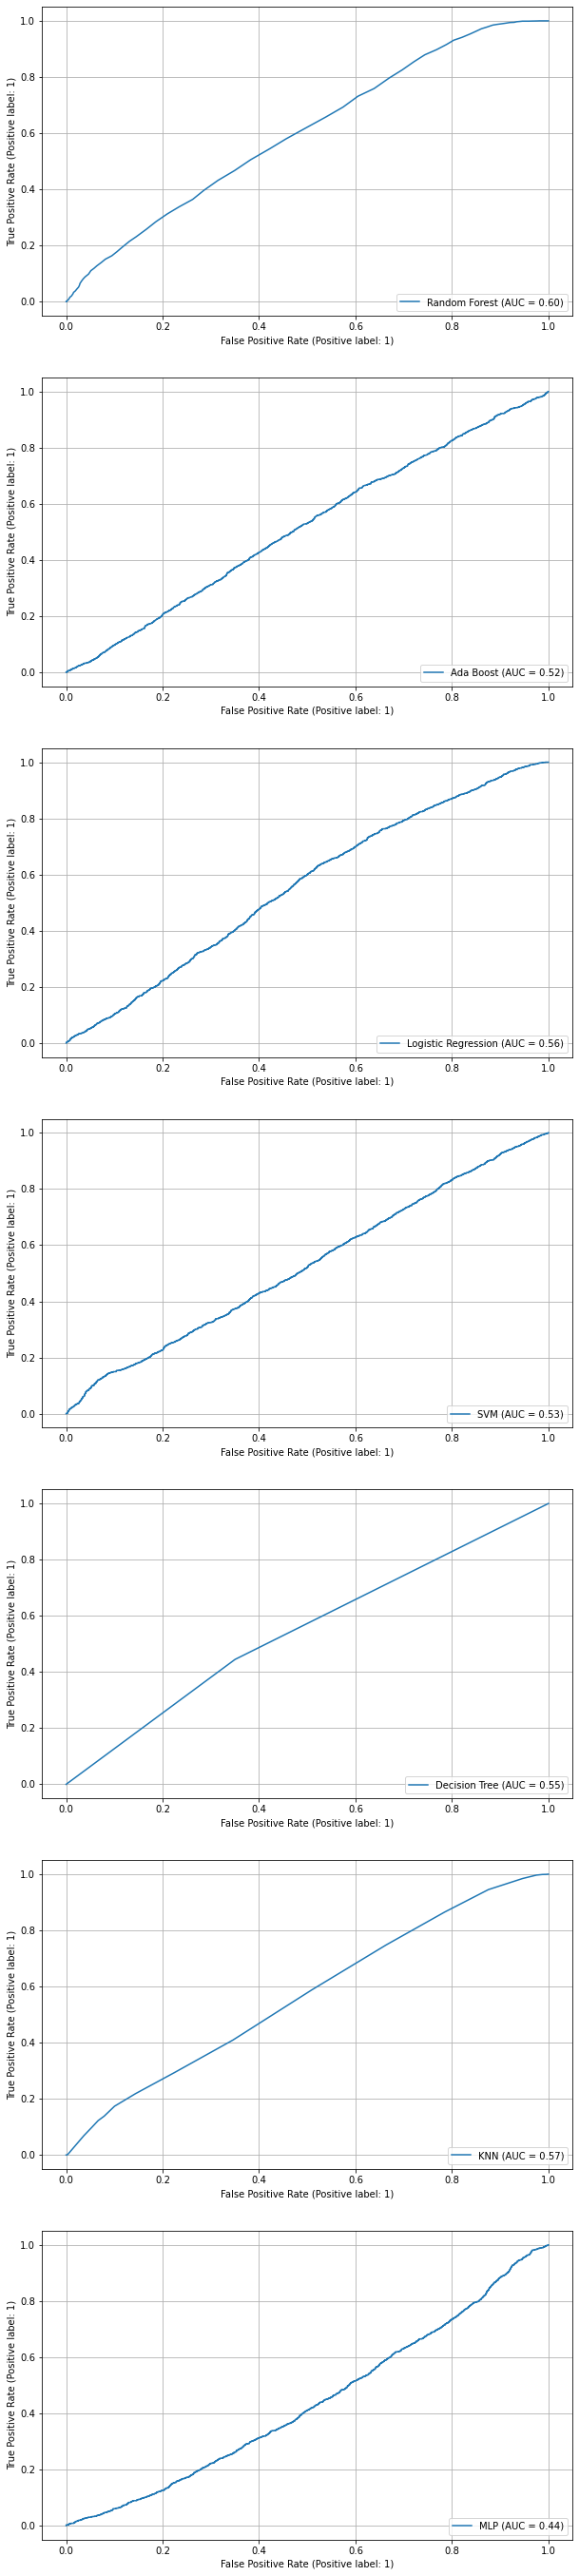

In [37]:
metrics_list = []
figure, axis = plt.subplots(len(classifiers), figsize=(10, 7*len(classifiers)), sharey=False)
count=0
for classifier in classifiers:
    classifiers[classifier].fit(train_data, train_label)
    pred = classifiers[classifier].predict(test_data)
    pred_score = classifiers[classifier].predict_proba(test_data)
    f1_score = metrics.f1_score(test_label, pred)
    precision = metrics.precision_score(test_label, pred)
    recall = metrics.recall_score(test_label, pred)
    acc = metrics.accuracy_score(test_label, pred)
    auc = metrics.roc_auc_score(test_label, pred_score[:,1])
    metrics_list.append({
        'classifier': classifier,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': acc,
        'area under curve': auc,
    })
    metrics.RocCurveDisplay.from_predictions(test_label, pred_score[:,1], name=classifier, ax=axis[count])
    axis[count].grid()
    count += 1
plt.show()

In [38]:
df_metrics = pd.DataFrame(metrics_list)

In [39]:
df_metrics

,classifier,precision,recall,f1_score,accuracy,area under curve
0,Random Forest,0.613579,0.364081,0.456994,0.538369,0.601618
1,Ada Boost,0.544234,0.259413,0.351351,0.488951,0.517820
2,Logistic Regression,0.545455,0.038404,0.071755,0.469867,0.556295
3,SVM,0.657944,0.132530,0.220620,0.500402,0.526524
4,Decision Tree,0.592277,0.444654,0.507957,0.540378,0.547262
5,KNN,0.598926,0.294051,0.394444,0.518280,0.566858
6,MLP,0.000000,0.000000,0.000000,0.466452,0.438230
